# Applying Time Series Regression to Ocean Gauge Data

Christopher Liu 

Contact: cmhl@uw.edu

-----
[tsfresh](https://tsfresh.readthedocs.io/) is required to run this notebook

In [1]:
%matplotlib inline

In [2]:
import numpy as np

from scipy.interpolate import interp1d

from pylab import *
from IPython.display import Image

np.set_printoptions(threshold=1000) # edit as needed

## Plots

Plots of the original uninterpolated data.

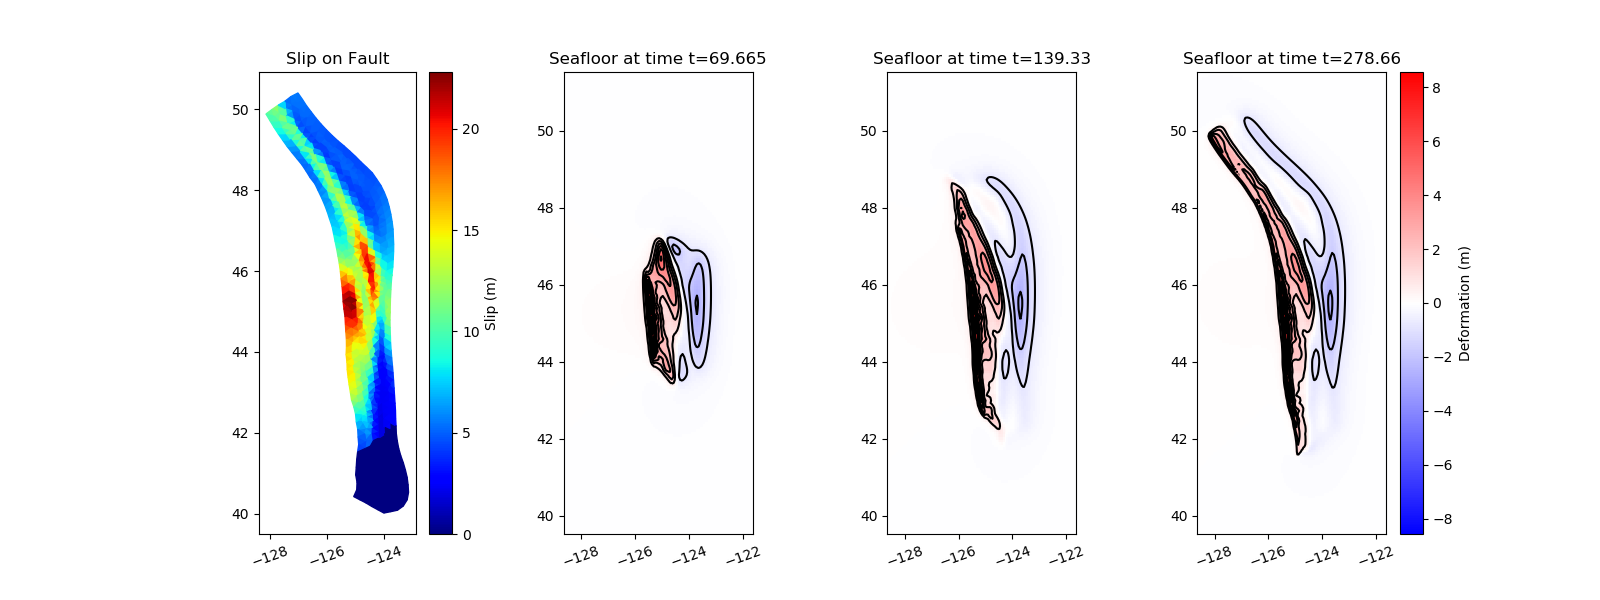

In [3]:
rnum = 1297   # run number
dtopo_png = 'C:/Users/Chris/Desktop/SJDF_files/dtopo/cascadia%s.png' % str(rnum).zfill(6)
Image(dtopo_png, width=900)

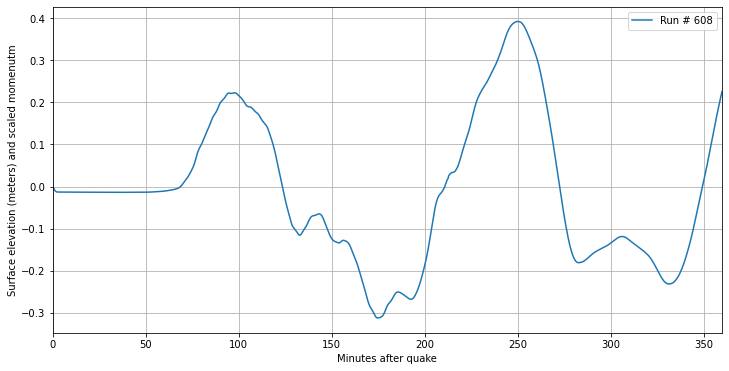

In [4]:
rnums = range(608,609)
etamax = {}


figure(figsize=(12,6))
for rnum in rnums:
    outdir = 'C:/Users/Chris/Desktop/SJDF_files/gauges/run_%s/_output' % str(rnum).zfill(6)
    #print('outdir = ', outdir)

    gaugenos = [702]
    for gaugeno in gaugenos:
        gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
        gdata = loadtxt(gfile)
        t = gdata[:,1] / 60.  # minutes
        eta = gdata[:,5]  # surface elevation in meters
        plot(t, eta, label='Run # %s' % rnum)
        etamax[(rnum,gaugeno)] = eta.max()

xlim(0, 360)
xlabel('Minutes after quake')
ylabel('Surface elevation (meters) and scaled momenutm')
grid(True)
legend()

# Load Data

This step can be skipped if loading the features/data frame directly

In [5]:
rnums = range(0,1300)
gaugenos = [702,712,901,902,911,912]

eta = {}
t = {}
for rnum in rnums:
    outdir = 'C:/Users/Chris/Desktop/gauge_data/run_%s/' % str(rnum).zfill(6)
    
    for gaugeno in gaugenos:
        gfile = '%s/gauge%s.txt' % (outdir, str(gaugeno).zfill(5))
        gdata = np.genfromtxt(gfile, delimiter=',')
        
        # data in this case has a NaN value for eta @ t=0
        t[(rnum,gaugeno)] = gdata[1:,0]  # seconds
        eta[(rnum,gaugeno)] = gdata[1:,1]  # surface elevation in meters

In [6]:
# plot(t[(95,702)]/60,eta[(95,702)])

# xlim(0, 360)
# xlabel('Minutes after quake')
# ylabel('Surface elevation (meters)')
# grid(True)

# Featurize

In [7]:
import pandas as pd

from tsfresh import extract_features, select_features
from tsfresh.feature_selection import relevance
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import ComprehensiveFCParameters

In [8]:
def max_eta(data,gaugeno,runs):
    """
    Finds the max eta for a specific gauge and run(s)
    Input:
        data - Dictionary of timeseries data with the form: data[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - List or range of run numbers to find the max value for
    
    Output:
        eta_max - np array containing the maximum values.
    """
    eta_max = []
    for rnum in runs:
        eta_max.append(np.amax(data[(rnum,gaugeno)]))
    return np.array(eta_max)

In [9]:
def get_thresh(data,threshold):
    """
    Finds index of time series when threshold is met or exceeded
    Input:
        data - Numpy array of time series
        threshold - int/double that each entry in the time series is compared against 
        
    Returns:
        i - Integer index of time series when threshold is met or exceeded
            OR
        math.nan - Returns NaN if threshold is not met/exceeded
    """
    for i in range(len(data)):
        if np.abs(data[i]) >= threshold:
            return i
    return math.nan

In [10]:
def stack_series(data, time, gaugeno, runs, threshold, tsteps):
    
    """
    Stacks the time series used to construct the dataframe for feature extraction
    Input:
        data - Dictionary of eta data with the form: data[(run_number, gauge_number)]
        time - Dictionary of time intervals of the form: time[(run_number, gauge_number)]
        gaugeno - Integer gauge number
        runs - Integer total number of runs
        threshold - int/double that each entry in the time series is compared against 
        tsteps - Number of time steps to extract after threshold is met
        
    Returns:
        g - Stacked eta time series of the form [(Run#0000,Gauge#702),(Run#0001,Gauge#702), ..., (Run#1299,Gauge#702)]
        run_id - ID used to identify which run number the time series belongs to, ranges from 0 to 1299
        runs_used - List containing the run numbers used (met the threshold). Not used for feature extraction
        times - The time scale/interval corresponding to an eta time series
        tstart - The indices where each time series met or exceeded the threshold. Not used for feature extraction
    """
    rnums = range(0,runs)
    
    runs_used = []
    g = []
    times = []
    run_id = []
    tstart = []
    
    for rnum in rnums:
        g_data = data[(rnum,gaugeno)]
        t_data = time[(rnum,gaugeno)]
        ind = get_thresh(g_data,threshold) #returns NaN if threshold is not met/exceeded
        
        if not math.isnan(ind): #ignore run if NaN
            runs_used.append(rnum)
            tstart.append(ind)
            
            #checking to see if there is enough data after threshold is met/exceeded
            if ind+tsteps < len(g_data):
                g.extend(g_data[ind:ind+tsteps].tolist())
                times.extend(t_data[ind:ind+tsteps].tolist())
                run_id.extend((np.ones(tsteps)*rnum).tolist())
            else:
                g.extend(g_data[ind:].tolist())
                times.extend(t_data[ind:].tolist())
                run_id.extend((np.ones(len(g_data)-ind)*rnum).tolist())

    return g, run_id, runs_used, times, tstart

In [11]:
tsteps = 361

eta_g702, run_id, runs_used, times, tstart =stack_series(eta, t, 702, 1300, 0.1, tsteps)

#### Histogram of when time when threshold is met/exceeded

Text(0, 0.5, 'Frequency')

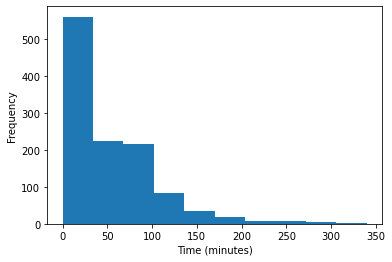

In [12]:
plt.hist(np.array(tstart)*(1/6))
plt.xlabel('Time (minutes)')
plt.ylabel('Frequency')

### Create dataframe and extract features
Skip if loading features from a .csv

In [13]:
dict = {'id':run_id, 'time':times, 'eta': eta_g702}
df = pd.DataFrame(dict)

# export datafrane used for feature extraction 
# df.to_csv(r'GaugeData1hr_818.csv', index=False) 

In [14]:
# This takes awhile to run. I keep it commented it out in case I accidentally run all cells. 

 feat702 = extract_features(df, column_id='id', column_sort='time', impute_function=impute)

Feature Extraction: 100%|██████████████████████████████████████████████████████████████| 10/10 [01:54<00:00, 11.44s/it]


### Import/Export feature dataframe
Comment/Uncomment as needed

In [15]:
# importing or exporting features to save computation time

# export features
# feat702.to_csv(r'feat702_1hr_826.csv', index=False)

# import features
# feat702 = pd.read_csv (r'feat702_816.csv')

### Creating/loading the max eta for desired gauges
Comment/uncomment the relevant block

In [16]:
# Creating/loading the max eta for desired gauges

# find max eta for gauges

g901max = max_eta(eta,901,runs_used)
g902max = max_eta(eta,902,runs_used)
g911max = max_eta(eta,911,runs_used)
g912max = max_eta(eta,912,runs_used)

# load max eta for gauges

# g901max = np.loadtxt('g901max.csv', delimiter=',')
# g902max = np.loadtxt('g902max.csv', delimiter=',')
# g911max = np.loadtxt('g911max.csv', delimiter=',')
# g912max = np.loadtxt('g912max.csv', delimiter=',')

# save max eta for gauges

# savetxt('g901max.csv', g901max, delimiter=',')
# savetxt('g902max.csv', g912max, delimiter=',')
# savetxt('g911max.csv', g901max, delimiter=',')
# savetxt('g912max.csv', g912max, delimiter=',')

### Filter features

Refer to https://tsfresh.readthedocs.io/en/latest/text/feature_filtering.html for more info

In [17]:
feat702_filt901 = select_features(feat702,g901max,ml_task='regression')

In [18]:
feat702_filt902 = select_features(feat702,g902max,ml_task='regression')

In [19]:
feat702_filt911 = select_features(feat702,g911max,ml_task='regression')

In [20]:
feat702_filt912 = select_features(feat702,g912max,ml_task='regression')

## Build and Test Model

In [21]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score

In [22]:
# Some constants used for training and visualization

numruns = len(runs_used)
testsize = 0.4

### Gauge 901

#### Unfiltered

In [23]:
train_901, test_901, train_901_target, test_901_target = train_test_split(feat702, g901max, test_size=testsize)

In [24]:
# Train model for gauge 901 using unfilited data. rbf and scale are default parameters
regress901 = SVR(kernel='rbf',gamma='scale')
regress901.fit(train_901, train_901_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [25]:
pred_901 = regress901.predict(test_901)

Text(0.5, 1.0, 'Gauge 901 (Unfiltered)')

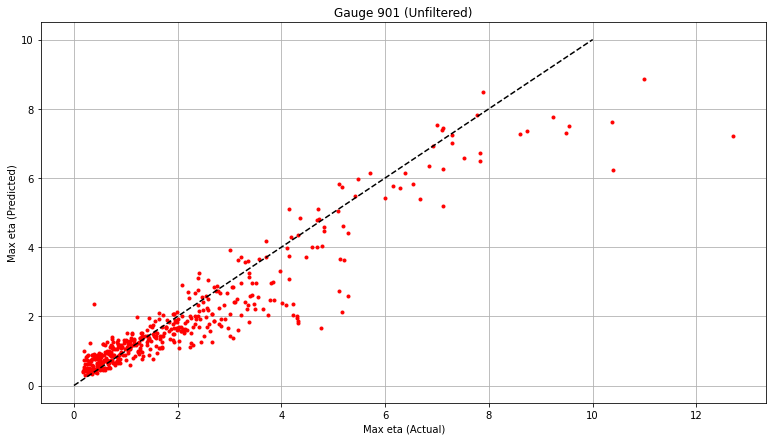

In [26]:
figure(figsize=(13,7))
plt.plot(test_901_target,pred_901,'r.')
plot([0,10],[0,10],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 901 (Unfiltered)')

In [27]:
explained_variance_score(test_901_target,pred_901)

0.8715771958789074

#### Filtered

In [39]:
train_901_f, test_901_f, train_901_f_target, test_901_f_target = train_test_split(feat702_filt901, g901max, test_size=testsize)

In [40]:
#Train model for gauge 901 using filtered data. rbf and scale are default parameters
regress901_f = SVR(kernel='rbf',gamma='scale')
regress901_f.fit(train_901_f, train_901_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [41]:
pred_901_f = regress901_f.predict(test_901_f)

Text(0.5, 1.0, 'Gauge 901 (Filtered)')

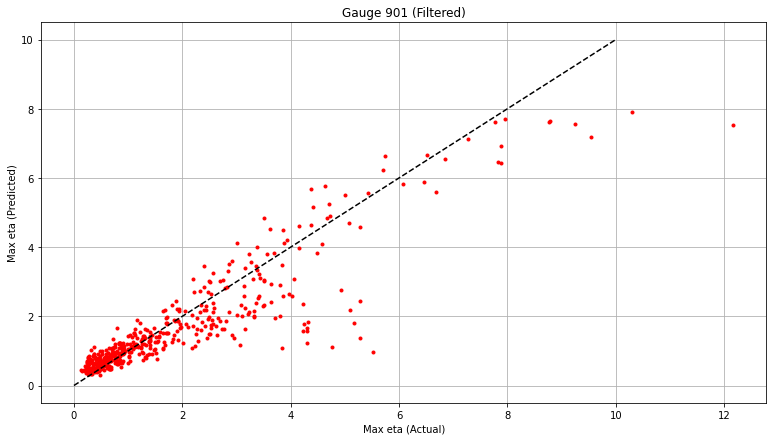

In [42]:
figure(figsize=(13,7))
plt.plot(test_901_f_target,pred_901_f,'r.')
plot([0,10],[0,10],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 901 (Filtered)')

In [ ]:
explained_variance_score(test_901_f_target,pred_901_f)

### Gauge 902

In [43]:
train_902, test_902, train_902_target, test_902_target = train_test_split(feat702, g902max, test_size=testsize)

In [44]:
regress902 = SVR(kernel='rbf',gamma='scale')
regress902.fit(train_902, train_902_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [45]:
pred_902 = regress901.predict(test_902)

Text(0.5, 1.0, 'Gauge 902 (Unfiltered)')

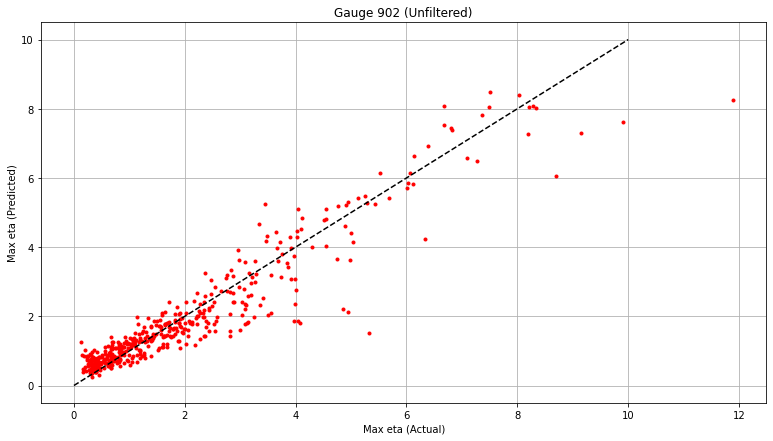

In [46]:
figure(figsize=(13,7))
plt.plot(test_902_target,pred_902,'r.')
plot([0,10],[0,10],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 902 (Unfiltered)')

In [47]:
explained_variance_score(test_902_target,pred_902)

0.8896485805761812

In [48]:
# Filtered
train_902_f, test_902_f, train_902_f_target, test_902_f_target = train_test_split(feat702_filt902, g902max, test_size=testsize)

In [49]:
#Train model for gauge 902 using filtered data. rbf and scale are default parameters
regress902_f = SVR(kernel='rbf',gamma='scale')
regress902_f.fit(train_902_f, train_902_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [50]:
pred_902_f = regress902_f.predict(test_902_f)

Text(0.5, 1.0, 'Gauge 902 (Filtered)')

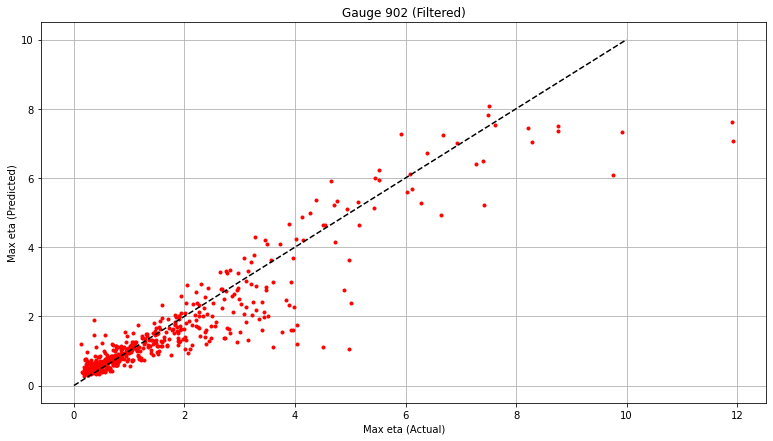

In [51]:
figure(figsize=(13,7))
plt.plot(test_902_f_target,pred_902_f,'r.')
plot([0,10],[0,10],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 902 (Filtered)')

In [52]:
explained_variance_score(test_902_f_target,pred_902_f)

0.846238627218962

### Gauge 911

In [57]:
train_911, test_911, train_911_target, test_911_target = train_test_split(feat702, g911max, test_size=testsize)

In [58]:
#Train model for gauge 911 using unfilited data. rbf and scale are default parameters
regress911= SVR(kernel='rbf',gamma='scale')
regress911.fit(train_911, train_911_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [61]:
pred_911 = regress911.predict(test_911)

Text(0.5, 1.0, 'Gauge 911 (Unfiltered)')

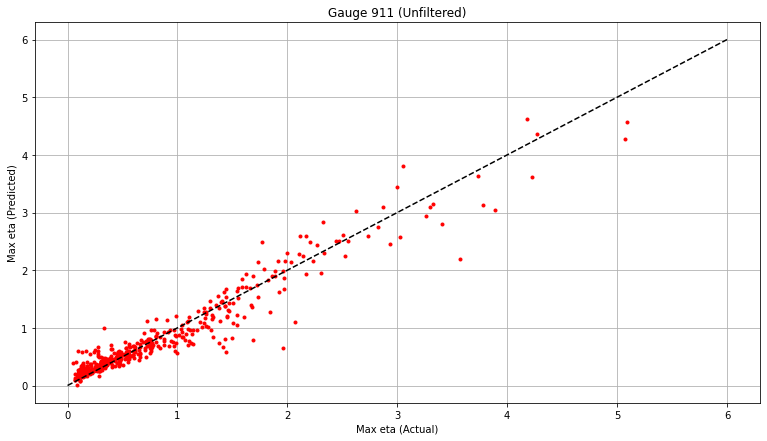

In [62]:
figure(figsize=(13,7))
plt.plot(test_911_target,pred_911,'r.')
plot([0,6],[0,6],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 911 (Unfiltered)')

In [63]:
explained_variance_score(test_911_target,pred_911)

0.9254764000631925

In [64]:
# filtered
train_911_f, test_911_f, train_911_f_target, test_911_f_target = train_test_split(feat702_filt911, g911max, test_size=testsize)

In [65]:
# Train model for gauge 911 using filtered data. rbf and scale are default parameters
regress911_f = SVR(kernel='rbf',gamma='scale')
regress911_f.fit(train_911_f, train_911_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [68]:
pred_911_f = regress911_f.predict(test_911_f)

Text(0.5, 1.0, 'Gauge 911 (Filtered)')

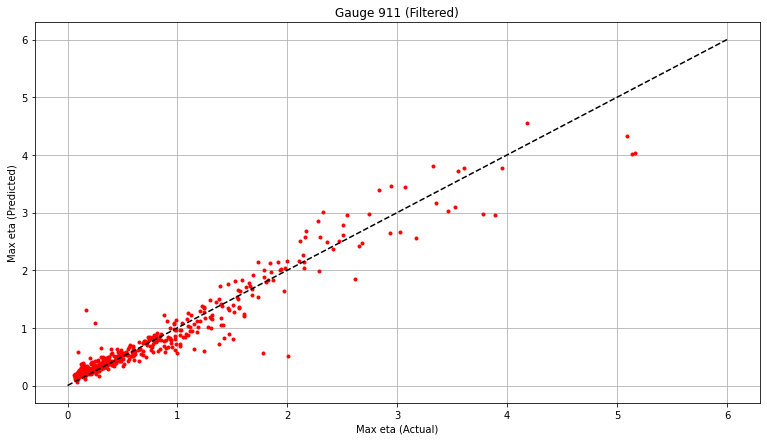

In [69]:
figure(figsize=(13,7))
plt.plot(test_911_f_target,pred_911_f,'r.')
plot([0,6],[0,6],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 911 (Filtered)')

In [70]:
explained_variance_score(test_911_f_target,pred_911_f)

0.9284741748616256

### Gauge 912

In [71]:
#unfiltered
train_912, test_912, train_912_target, test_912_target = train_test_split(feat702, g912max, test_size=testsize)

In [72]:
#Train model for gauge 912 using unfilited data. rbf and scale are default parameters
regress912 = SVR(kernel='rbf',gamma='scale')
regress912.fit(train_912, train_912_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [73]:
pred_912 = regress912.predict(test_912)

Text(0.5, 1.0, 'Gauge 912 (Unfiltered)')

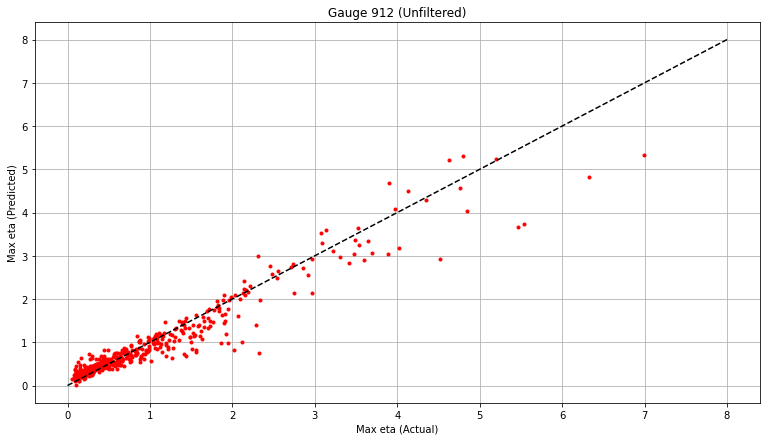

In [74]:
figure(figsize=(13,7))
plt.plot(test_912_target,pred_912,'r.')
plot([0,8],[0,8],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 912 (Unfiltered)')

In [75]:
explained_variance_score(test_912_target,pred_912)

0.9190494873872913

In [76]:
#filtered
train_912_f, test_912_f, train_912_f_target, test_912_f_target = train_test_split(feat702_filt912, g912max, test_size=testsize)

In [77]:
#Train model for gauge 912 using filtered data. rbf and scale are default parameters
regress912_f = SVR(kernel='rbf',gamma='scale')
regress912_f.fit(train_912_f, train_912_f_target, sample_weight=None)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [78]:
pred_912_f = regress912_f.predict(test_912_f)

Text(0.5, 1.0, 'Gauge 912 (Filtered)')

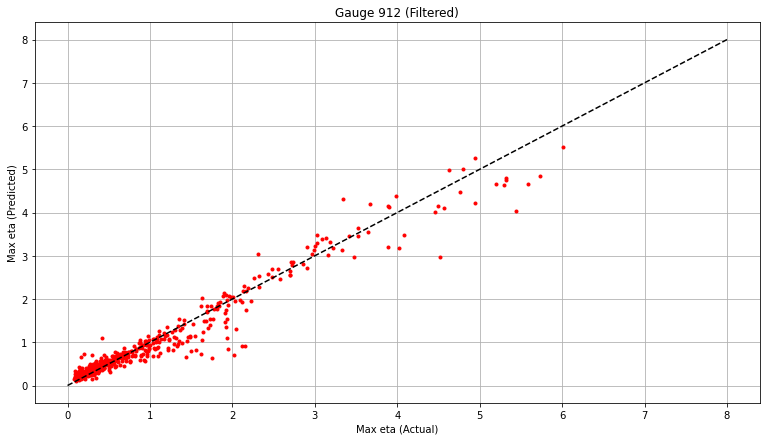

In [79]:
figure(figsize=(13,7))
plt.plot(test_912_f_target,pred_912_f,'r.')
plot([0,8],[0,8],'k--')
xlabel('Max eta (Actual)')
ylabel('Max eta (Predicted)')
grid(True)
title('Gauge 912 (Filtered)')

In [80]:
explained_variance_score(test_912_f_target,pred_912_f)

0.9459844959983648